Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# План работы:

1) [Изучение и обработка данных.](#id_1)

2) [Обучение моделей, подборка гиперпараметров.](#id_2)

3) [Анализ работы моделей.](#id_3)

4) [Общий вывод.](#id_4)

5) [Бонус.](#id_5)

<a id='id_1'></a>
# 1. Подготовка данных

In [1]:
# Импортируем все необходимые библиотеки
# В процессе работы список будет пополняться
import pandas as pd
import numpy as np
import time
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

## 1.1 Чтение данных

In [2]:
data = pd.read_csv('/datasets/autos.csv')
data.info()
data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
data.isnull().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Данные загружены, время анализировать.
У нас имеются 16 колонок и 354369 строк. В столбцах VehicleType, Gearbox, Model, FuelType и NotRepaired - есть пропущенные значения. 

In [4]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


В колонках Цена и Мощность - присутствуют нулевые значения, их следует обработать. Значения в столбце Количество фотографий - везде ноль, его можно смело удалять, на анализ он никак не влияет. Аналогично, для анализа нам не пригодятся так же столбцы PostalCode и RegistrationMonth (на цену они не влияют, в то время как качество модели может страдать). Так же есть аномальные значения в столбце RegistrationYear.

## 1.2 Обработка пропусков и аномалий

In [5]:
del data['PostalCode'], data['NumberOfPictures'], data['RegistrationMonth']
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 13 columns):
DateCrawled         354369 non-null object
Price               354369 non-null int64
VehicleType         316879 non-null object
RegistrationYear    354369 non-null int64
Gearbox             334536 non-null object
Power               354369 non-null int64
Model               334664 non-null object
Kilometer           354369 non-null int64
FuelType            321474 non-null object
Brand               354369 non-null object
NotRepaired         283215 non-null object
DateCreated         354369 non-null object
LastSeen            354369 non-null object
dtypes: int64(4), object(9)
memory usage: 35.1+ MB


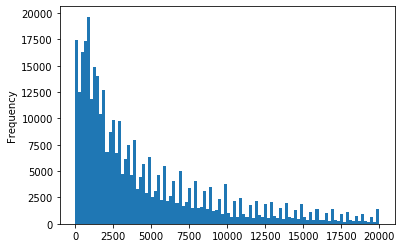

In [6]:
# Обработаем столбец Price
data.Price.plot(kind='hist', bins =100)

In [7]:
# Значения с ценой = 0 явный выброс, удаляем все нулевые значения
data = data.query('Price > 0')
data.Price.sort_values().head(10)

25095     1
353252    1
66163     1
134280    1
66253     1
89957     1
192113    1
66308     1
184965    1
1340      1
Name: Price, dtype: int64

In [8]:
# Теперь минимальная цена = 1? Попробуем минимальную цену от 200 Евро
data = data.query('Price > 200')
data.Price.sort_values().head(10)

290665    202
28094     205
36284     205
175108    209
183153    209
101354    210
4345      210
89295     210
183570    210
143413    210
Name: Price, dtype: int64

In [9]:
# Обработаем столбец Power
# Чтобы избавиться от аномальных значений, возьмем диапозон мощности от 60 до 250 л.с.
data = data.query('Power > 60 & Power < 250')
data.describe()

,Price,RegistrationYear,Power,Kilometer
count,258056.000000,258056.000000,258056.000000,258056.000000
mean,5160.274119,2003.955599,124.844018,128561.920668
std,4537.471408,28.786962,41.313916,36734.986192
min,202.000000,1000.000000,61.000000,5000.000000
25%,1650.000000,2000.000000,90.000000,125000.000000
50%,3600.000000,2004.000000,116.000000,150000.000000
75%,7400.000000,2008.000000,150.000000,150000.000000
max,20000.000000,9999.000000,249.000000,150000.000000


In [10]:
# Обработаем столбец RegistrationYear
data['RegistrationYear'].sort_values(ascending=True).head(30)

256532    1000
18224     1500
203230    1910
23750     1910
62803     1910
295868    1937
338109    1937
88033     1942
230679    1942
305821    1943
326241    1947
271162    1948
27525     1949
103192    1950
74705     1950
174755    1950
85423     1951
111389    1951
163050    1951
133222    1952
254249    1952
34572     1953
317802    1953
284693    1954
186403    1955
109349    1955
171996    1955
316508    1955
274861    1956
258928    1956
Name: RegistrationYear, dtype: int64

In [11]:
data['RegistrationYear'].sort_values(ascending=False).head(30)

128677    9999
320452    8200
158283    6000
53678     5911
326556    5911
229905    5000
124840    5000
309880    5000
322234    5000
146507    5000
278390    4500
46741     2900
255866    2800
101989    2019
35506     2019
148759    2019
62996     2019
57074     2019
74469     2019
62809     2019
178620    2019
182995    2018
65332     2018
65460     2018
311098    2018
97133     2018
24364     2018
274414    2018
97701     2018
275618    2018
Name: RegistrationYear, dtype: int64

In [12]:
# Есть много выбросов (такие как год регистрации автомобиля больше 2019 или меньше 1942), удалим их
data = data.query('RegistrationYear > 1980 & RegistrationYear < 2020')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 256666 entries, 1 to 354368
Data columns (total 13 columns):
DateCrawled         256666 non-null object
Price               256666 non-null int64
VehicleType         240141 non-null object
RegistrationYear    256666 non-null int64
Gearbox             252419 non-null object
Power               256666 non-null int64
Model               247454 non-null object
Kilometer           256666 non-null int64
FuelType            241679 non-null object
Brand               256666 non-null object
NotRepaired         220099 non-null object
DateCreated         256666 non-null object
LastSeen            256666 non-null object
dtypes: int64(4), object(9)
memory usage: 27.4+ MB


In [13]:
# Обработаем столбец VehicleType
data['VehicleType'].value_counts()

sedan          76438
wagon          56993
small          39736
bus            25599
convertible    17253
coupe          12327
suv             9780
other           2015
Name: VehicleType, dtype: int64

In [14]:
data['VehicleType'].isnull().sum()

16525

In [15]:
# Всего у нас пропущено 18212 значений. Самостоятельно заполнить у нас возможности нет, т.к. нельзя выделить какое-либо 
# лидирующее значение, так что пропуски мы удалим
data.dropna(subset=['VehicleType'], inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240141 entries, 1 to 354368
Data columns (total 13 columns):
DateCrawled         240141 non-null object
Price               240141 non-null int64
VehicleType         240141 non-null object
RegistrationYear    240141 non-null int64
Gearbox             237200 non-null object
Power               240141 non-null int64
Model               233083 non-null object
Kilometer           240141 non-null int64
FuelType            231891 non-null object
Brand               240141 non-null object
NotRepaired         210800 non-null object
DateCreated         240141 non-null object
LastSeen            240141 non-null object
dtypes: int64(4), object(9)
memory usage: 25.6+ MB


In [16]:
# Обработаем столбец Gearbox
data['Gearbox'].value_counts()

manual    187828
auto       49372
Name: Gearbox, dtype: int64

In [17]:
# Большинство значений - manual, а значит пропуски заполним этим значением
data['Gearbox'] = data['Gearbox'].fillna('manual')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240141 entries, 1 to 354368
Data columns (total 13 columns):
DateCrawled         240141 non-null object
Price               240141 non-null int64
VehicleType         240141 non-null object
RegistrationYear    240141 non-null int64
Gearbox             240141 non-null object
Power               240141 non-null int64
Model               233083 non-null object
Kilometer           240141 non-null int64
FuelType            231891 non-null object
Brand               240141 non-null object
NotRepaired         210800 non-null object
DateCreated         240141 non-null object
LastSeen            240141 non-null object
dtypes: int64(4), object(9)
memory usage: 25.6+ MB


In [18]:
# Пропуски в столбце Model самостоятельно восстановить не получится (заполнять пропуски модальным значением может быть ошибкой)
# Просто удаляем нули
data.dropna(subset=['Model'], inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 233083 entries, 2 to 354368
Data columns (total 13 columns):
DateCrawled         233083 non-null object
Price               233083 non-null int64
VehicleType         233083 non-null object
RegistrationYear    233083 non-null int64
Gearbox             233083 non-null object
Power               233083 non-null int64
Model               233083 non-null object
Kilometer           233083 non-null int64
FuelType            226188 non-null object
Brand               233083 non-null object
NotRepaired         205948 non-null object
DateCreated         233083 non-null object
LastSeen            233083 non-null object
dtypes: int64(4), object(9)
memory usage: 24.9+ MB


In [19]:
# Столбцы FuelType и NotRepaired - пропуски заменим на самые частые значения
data['FuelType'].value_counts()

petrol      139816
gasoline     81988
lpg           3734
cng            417
hybrid         174
other           35
electric        24
Name: FuelType, dtype: int64

In [20]:
data['FuelType']=data['FuelType'].fillna('petrol')
data['NotRepaired'].value_counts()

no     185264
yes     20684
Name: NotRepaired, dtype: int64

In [21]:
data['NotRepaired']=data['NotRepaired'].fillna('no')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 233083 entries, 2 to 354368
Data columns (total 13 columns):
DateCrawled         233083 non-null object
Price               233083 non-null int64
VehicleType         233083 non-null object
RegistrationYear    233083 non-null int64
Gearbox             233083 non-null object
Power               233083 non-null int64
Model               233083 non-null object
Kilometer           233083 non-null int64
FuelType            233083 non-null object
Brand               233083 non-null object
NotRepaired         233083 non-null object
DateCreated         233083 non-null object
LastSeen            233083 non-null object
dtypes: int64(4), object(9)
memory usage: 24.9+ MB


Итак, пропуски все обработаны. Датафрейм теперь состоит из 233083 строк, вместо 354369 изначальных. Потери в количестве немалые, зато мы приобрели в качестве.

Для корректной работы модели - нам не пригодятся столбцы DataCrawled, DateCreated, LastSeen (на цену они не влияют).

In [22]:
del data['DateCrawled'], data['DateCreated'], data['LastSeen']
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 233083 entries, 2 to 354368
Data columns (total 10 columns):
Price               233083 non-null int64
VehicleType         233083 non-null object
RegistrationYear    233083 non-null int64
Gearbox             233083 non-null object
Power               233083 non-null int64
Model               233083 non-null object
Kilometer           233083 non-null int64
FuelType            233083 non-null object
Brand               233083 non-null object
NotRepaired         233083 non-null object
dtypes: int64(4), object(6)
memory usage: 19.6+ MB


## 1.3 Преобразование данных

In [23]:
# Отделим целевой признак от признаков
data_target = data['Price']
data_features = data.drop('Price', axis=1)
# data_features2 понадобится нам позже
data_features2 = data.drop('Price', axis=1)
data_features.head(5)

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
2,suv,2004,auto,163,grand,125000,gasoline,jeep,no
3,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
6,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no


In [24]:
# Теперь следует преобразовать данные
data_features = pd.get_dummies(data_features, drop_first=True)
data_features.describe()

,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,...,Brand_seat,Brand_skoda,Brand_smart,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_yes
count,233083.000000,233083.000000,233083.000000,233083.000000,233083.00000,233083.000000,233083.000000,233083.000000,233083.000000,233083.000000,...,233083.000000,233083.000000,233083.000000,233083.000000,233083.000000,233083.000000,233083.000000,233083.000000,233083.000000,233083.000000
mean,2003.363411,125.573607,128211.903056,0.071794,0.05060,0.007976,0.319131,0.165430,0.040102,0.238023,...,0.017603,0.018414,0.010782,0.002244,0.006869,0.016196,0.000004,0.208943,0.011022,0.088741
std,5.552585,41.414567,36735.280458,0.258147,0.21918,0.088950,0.466141,0.371569,0.196198,0.425874,...,0.131504,0.134443,0.103273,0.047316,0.082593,0.126229,0.002071,0.406554,0.104405,0.284370
min,1981.000000,61.000000,5000.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2000.000000,95.000000,125000.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2004.000000,116.000000,150000.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2007.000000,150.000000,150000.000000,0.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2018.000000,249.000000,150000.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [25]:
# Нормализуем данные
scaler = StandardScaler()
scaler.fit(data_features)
data_norm_feat = scaler.transform(data_features)
data_norm_feat = pd.DataFrame(data_norm_feat, columns=data_features.columns)
data_norm_feat.describe()

,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,...,Brand_seat,Brand_skoda,Brand_smart,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_yes
count,2.330830e+05,2.330830e+05,2.330830e+05,2.330830e+05,2.330830e+05,2.330830e+05,2.330830e+05,2.330830e+05,2.330830e+05,2.330830e+05,...,2.330830e+05,2.330830e+05,2.330830e+05,2.330830e+05,2.330830e+05,2.330830e+05,2.330830e+05,2.330830e+05,2.330830e+05,2.330830e+05
mean,-1.266803e-14,-1.726644e-16,1.076104e-16,-1.746764e-17,8.901485e-18,-5.182371e-18,-4.089501e-17,6.923038e-17,6.333163e-17,1.027024e-16,...,6.322493e-17,1.652262e-17,2.726842e-17,-9.648356e-18,1.864129e-17,5.343939e-17,-1.234624e-18,9.104207e-17,-2.627767e-17,5.456732e-18
std,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,...,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00
min,-4.027576e+00,-1.559204e+00,-3.354055e+00,-2.781137e-01,-2.308610e-01,-8.966506e-02,-6.846249e-01,-4.452217e-01,-2.043940e-01,-5.589049e-01,...,-1.338604e-01,-1.369652e-01,-1.043986e-01,-4.742238e-02,-8.316432e-02,-1.283066e-01,-2.071313e-03,-5.139368e-01,-1.055683e-01,-3.120621e-01
25%,-6.057392e-01,-7.382348e-01,-8.743393e-02,-2.781137e-01,-2.308610e-01,-8.966506e-02,-6.846249e-01,-4.452217e-01,-2.043940e-01,-5.589049e-01,...,-1.338604e-01,-1.369652e-01,-1.043986e-01,-4.742238e-02,-8.316432e-02,-1.283066e-01,-2.071313e-03,-5.139368e-01,-1.055683e-01,-3.120621e-01
50%,1.146475e-01,-2.311657e-01,5.931122e-01,-2.781137e-01,-2.308610e-01,-8.966506e-02,-6.846249e-01,-4.452217e-01,-2.043940e-01,-5.589049e-01,...,-1.338604e-01,-1.369652e-01,-1.043986e-01,-4.742238e-02,-8.316432e-02,-1.283066e-01,-2.071313e-03,-5.139368e-01,-1.055683e-01,-3.120621e-01
75%,6.549375e-01,5.898032e-01,5.931122e-01,-2.781137e-01,-2.308610e-01,-8.966506e-02,1.460654e+00,-4.452217e-01,-2.043940e-01,-5.589049e-01,...,-1.338604e-01,-1.369652e-01,-1.043986e-01,-4.742238e-02,-8.316432e-02,-1.283066e-01,-2.071313e-03,-5.139368e-01,-1.055683e-01,-3.120621e-01
max,2.636001e+00,2.980272e+00,5.931122e-01,3.595651e+00,4.331610e+00,1.115262e+01,1.460654e+00,2.246072e+00,4.892511e+00,1.789213e+00,...,7.470472e+00,7.301122e+00,9.578669e+00,2.108709e+01,1.202439e+01,7.793834e+00,4.827857e+02,1.945765e+00,9.472543e+00,3.204490e+00


In [26]:
# Создадим обучающую, валидационную и тестовую выборки в соотношение 60%, 20% и 20% соотвественно
x_train, x_another, y_train, y_another = train_test_split(data_norm_feat, data_target, random_state = 12345, test_size=0.4)
x_valid, x_test, y_valid, y_test = train_test_split(x_another, y_another, random_state=12345, test_size=0.5)
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139849 entries, 34339 to 217570
Columns: 300 entries, RegistrationYear to NotRepaired_yes
dtypes: float64(300)
memory usage: 321.2 MB


In [27]:
x_valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46617 entries, 226739 to 57561
Columns: 300 entries, RegistrationYear to NotRepaired_yes
dtypes: float64(300)
memory usage: 107.1 MB


In [28]:
x_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46617 entries, 132557 to 232739
Columns: 300 entries, RegistrationYear to NotRepaired_yes
dtypes: float64(300)
memory usage: 107.1 MB


<a id='id_2'></a>
# 2. Обучение моделей

### 2.1 LightGBM

In [30]:
# Подбираем параметры
for est in range (1, 52, 10):
    start=time.time()
    model=LGBMRegressor(n_estimators=est)
    model.fit(x_train, y_train)
    predict=model.predict(x_valid)
    accuracy=mean_squared_error(y_valid, predict)**0.5
    print(est, '-', accuracy, ', time', time.time()-start)

1 - 4244.234098352123 , time 10.720906019210815
11 - 2471.9096152062652 , time 15.905495643615723
21 - 1974.1403546799029 , time 55.499343395233154
31 - 1800.5334948739562 , time 115.13377690315247
41 - 1721.4429678344823 , time 38.65143036842346
51 - 1676.2552361522903 , time 40.31349992752075


In [31]:
# Значение 51 показывает самое меньшее значение RMSE, оставляем его
for depth in range (1, 5):
    start=time.time()
    model=LGBMRegressor(n_estimators=51, max_depth=depth)
    model.fit(x_train, y_train)
    predict=model.predict(x_valid)
    accuracy=mean_squared_error(y_valid, predict)**0.5
    print(depth, '-', accuracy, ', time', time.time()-start)

1 - 2552.08067804437 , time 19.885313749313354
2 - 2128.47570619306 , time 42.410908699035645
3 - 1943.4116783286865 , time 61.47873640060425
4 - 1819.5529383140845 , time 104.23098564147949


Остановимся на значении 4, т.к. последующие значения сильно увеличивают время работы при несильном уменьшении ошибки.

Параметры вышли следующие: n_estimators=51, max_depth=4.

In [32]:
lgbm = LGBMRegressor(n_estimators=51, max_depth=4)

### 2.2 Catboost

In [35]:
# Подбираем параметры
start=time.time()
model=CatBoostRegressor(iterations=133)
model.fit(x_train, y_train)
predict=model.predict(x_valid)
accuracy=mean_squared_error(y_valid, predict)**0.5

0:	learn: 4485.1100103	total: 19.6ms	remaining: 2.59s
1:	learn: 4394.4534728	total: 121ms	remaining: 7.92s
2:	learn: 4307.5791870	total: 223ms	remaining: 9.67s
3:	learn: 4222.1300258	total: 412ms	remaining: 13.3s
4:	learn: 4138.8425564	total: 517ms	remaining: 13.2s
5:	learn: 4058.6551578	total: 620ms	remaining: 13.1s
6:	learn: 3983.2740126	total: 723ms	remaining: 13s
7:	learn: 3909.8472916	total: 910ms	remaining: 14.2s
8:	learn: 3838.9247950	total: 1.01s	remaining: 13.9s
9:	learn: 3770.7379956	total: 1.11s	remaining: 13.7s
10:	learn: 3704.9741150	total: 1.22s	remaining: 13.5s
11:	learn: 3642.2738207	total: 1.32s	remaining: 13.3s
12:	learn: 3581.7405804	total: 1.51s	remaining: 13.9s
13:	learn: 3521.8448886	total: 1.61s	remaining: 13.7s
14:	learn: 3465.4789522	total: 1.71s	remaining: 13.5s
15:	learn: 3411.0804420	total: 1.9s	remaining: 13.9s
16:	learn: 3359.7478063	total: 2.01s	remaining: 13.7s
17:	learn: 3309.6667156	total: 2.11s	remaining: 13.5s
18:	learn: 3260.0457030	total: 2.3s	rema

In [34]:
start=time.time()
model=CatBoostRegressor(iterations=133, depth=11)
model.fit(x_train, y_train)
predict=model.predict(x_valid)
accuracy=mean_squared_error(y_valid, predict)**0.5


0:	learn: 4475.6870402	total: 174ms	remaining: 22.9s
1:	learn: 4376.3180310	total: 443ms	remaining: 29s
2:	learn: 4278.8524824	total: 653ms	remaining: 28.3s
3:	learn: 4186.4859574	total: 858ms	remaining: 27.7s
4:	learn: 4097.5601470	total: 1.14s	remaining: 29.3s
5:	learn: 4012.1732613	total: 1.35s	remaining: 28.6s
6:	learn: 3928.8747336	total: 1.57s	remaining: 28.3s
7:	learn: 3847.5089507	total: 1.84s	remaining: 28.8s
8:	learn: 3768.9883871	total: 2.07s	remaining: 28.5s
9:	learn: 3694.0209385	total: 2.34s	remaining: 28.8s
10:	learn: 3621.4688104	total: 2.55s	remaining: 28.3s
11:	learn: 3550.8818860	total: 2.84s	remaining: 28.6s
12:	learn: 3483.1971621	total: 3.04s	remaining: 28.1s
13:	learn: 3418.8205055	total: 3.34s	remaining: 28.4s
14:	learn: 3356.8959566	total: 3.54s	remaining: 27.9s
15:	learn: 3296.9643110	total: 3.75s	remaining: 27.4s
16:	learn: 3238.9539154	total: 4.03s	remaining: 27.5s
17:	learn: 3183.0834181	total: 4.26s	remaining: 27.2s
18:	learn: 3129.4726626	total: 4.53s	rem

In [36]:
# Лучший результат - 11
cb=CatBoostRegressor(iterations=133, depth=11)

Из подбора гиперпараметров можно сделать следующий вывод - чем больше значения у гиперпараметров - тем медленнее работает модель, но сильнее улучшается её качество. Остановимся, пока, на указанных выше параметрах.

### 2.3 DecissionTreeRegressor

In [37]:
for depth in range(1, 11):
    start=time.time()
    model = DecisionTreeRegressor(max_depth=depth, random_state=123)
    model.fit(x_train, y_train)
    predict = model.predict(x_valid)
    accuracy=mean_squared_error(y_valid, predict)**0.5
    print(depth, '-', accuracy, ', time', time.time()-start)

1 - 3464.6663199839168 , time 0.4322850704193115
2 - 3056.2761975192 , time 0.7429513931274414
3 - 2648.205769692134 , time 1.1814794540405273
4 - 2443.013437253702 , time 1.4017333984375
5 - 2305.7261520288816 , time 1.9774346351623535
6 - 2198.332200400508 , time 2.049873113632202
7 - 2107.6846440884033 , time 2.5690743923187256
8 - 2031.2557481450838 , time 2.5411767959594727
9 - 1975.0615487544746 , time 2.785043478012085
10 - 1910.166467417463 , time 3.0094387531280518


In [38]:
# Оставялем значение 10
for split in range(2, 11):
    start=time.time()
    model = DecisionTreeRegressor(max_depth=10, random_state=123, min_samples_split=split)
    model.fit(x_train, y_train)
    predict = model.predict(x_valid)
    accuracy=mean_squared_error(y_valid, predict)**0.5
    print(split, '-', accuracy, ', time', time.time()-start)

2 - 1910.166467417463 , time 2.973012924194336
3 - 1909.8074511274917 , time 3.0454769134521484
4 - 1905.9486683025254 , time 2.8953685760498047
5 - 1909.8016854665007 , time 3.1767163276672363
6 - 1907.7008143615099 , time 4.132702827453613
7 - 1909.5484992201293 , time 4.369153261184692
8 - 1909.006083516185 , time 2.91290545463562
9 - 1912.6853889835727 , time 2.9681591987609863
10 - 1911.4970160277314 , time 2.9392597675323486


In [39]:
# Лучшее значение - 4, хотя сильно оно показатели не меняет
dtr = DecisionTreeRegressor(max_depth=10, random_state=123, min_samples_split=4)

### 2.4 RandomForest

In [76]:
# ЭТА КОМАНДА ПОМОГАЕТ УБИРАТЬ ПРЕДУПРЕЖДЕНИЯ
import warnings
warnings.filterwarnings('ignore')

In [41]:
for depth in range(1, 11):
    start=time.time()
    model = RandomForestRegressor(max_depth=depth, random_state=123)
    model.fit(x_train, y_train)
    predict = model.predict(x_valid)
    accuracy=mean_squared_error(y_valid, predict)**0.5
    print(depth, '-', accuracy, ', time', time.time()-start)

1 - 3363.106332445761 , time 2.138859748840332
2 - 2951.264525083452 , time 4.314027309417725
3 - 2603.9356228898346 , time 6.7440338134765625
4 - 2389.240178170767 , time 9.293168306350708
5 - 2242.9009179876452 , time 10.916149139404297
6 - 2129.9535235228427 , time 13.219451189041138
7 - 2038.39039986463 , time 15.001970052719116
8 - 1951.5199560556102 , time 17.1714448928833
9 - 1881.8211315013436 , time 17.58962321281433
10 - 1819.545112026633 , time 18.965007543563843


In [42]:
# Лучшее значение - 10
for est in range (1, 11):
    start=time.time()
    model = RandomForestRegressor(max_depth=10, n_estimators=est, random_state=123)
    model.fit(x_train, y_train)
    predict = model.predict(x_valid)
    accuracy=mean_squared_error(y_valid, predict)**0.5
    print(est, '-', accuracy, ', time', time.time()-start)

1 - 1953.972526038666 , time 2.0808427333831787
2 - 1891.059853766587 , time 4.153751373291016
3 - 1862.7795458992875 , time 5.742893695831299
4 - 1849.078198876395 , time 7.540847063064575
5 - 1840.440788015788 , time 9.521743535995483
6 - 1833.102064412224 , time 11.390902996063232
7 - 1824.2340646136804 , time 13.496291637420654
8 - 1821.3136575968895 , time 15.003194808959961
9 - 1820.5408600644994 , time 16.77011728286743
10 - 1819.545112026633 , time 18.6054265499115


In [43]:
# Создаем модель
rf = RandomForestRegressor(max_depth=10, n_estimators=10, random_state=123)

## Вывод по п.2:
Теперь у нас есть 4 готовых модели с подобранными параметрами, в следующем пункте мы проверим их на тестовой выборке.

<a id='id_3'></a>
# 3. Анализ моделей

In [44]:
# LGBMRegressor
start=time.time()
lgbm.fit(x_train, y_train)
training_time = time.time()-start
second = time.time()
predict=lgbm.predict(x_test)
prediction_time = time.time()-second
accuracy=mean_squared_error(y_test, predict)**0.5
print("RMSE составляет" , accuracy, ', training_time', training_time, ', prediction_time', prediction_time)

RMSE составляет 1811.4306311844996 , training_time 27.16418147087097 , prediction_time 0.683499813079834


In [45]:
# CatBoost
start=time.time()
cb.fit(x_train, y_train)
training_time = time.time()-start
second = time.time()
predict=cb.predict(x_test)
prediction_time = time.time()-second
accuracy=mean_squared_error(y_test, predict)**0.5
print("RMSE составляет" , accuracy, ', training_time', training_time, ', prediction_time', prediction_time)

0:	learn: 4475.6870402	total: 191ms	remaining: 25.2s
1:	learn: 4376.3180310	total: 398ms	remaining: 26.1s
2:	learn: 4278.8524824	total: 604ms	remaining: 26.2s
3:	learn: 4186.4859574	total: 807ms	remaining: 26s
4:	learn: 4097.5601470	total: 1.09s	remaining: 27.9s
5:	learn: 4012.1732613	total: 1.29s	remaining: 27.4s
6:	learn: 3928.8747336	total: 1.5s	remaining: 27.1s
7:	learn: 3847.5089507	total: 1.79s	remaining: 28s
8:	learn: 3768.9883871	total: 2s	remaining: 27.6s
9:	learn: 3694.0209385	total: 2.29s	remaining: 28.1s
10:	learn: 3621.4688104	total: 2.49s	remaining: 27.6s
11:	learn: 3550.8818860	total: 2.7s	remaining: 27.2s
12:	learn: 3483.1971621	total: 2.98s	remaining: 27.5s
13:	learn: 3418.8205055	total: 3.19s	remaining: 27.1s
14:	learn: 3356.8959566	total: 3.4s	remaining: 26.7s
15:	learn: 3296.9643110	total: 3.68s	remaining: 26.9s
16:	learn: 3238.9539154	total: 3.88s	remaining: 26.5s
17:	learn: 3183.0834181	total: 4.09s	remaining: 26.1s
18:	learn: 3129.4726626	total: 4.38s	remaining: 

In [46]:
# DecissionTree
start=time.time()
dtr.fit(x_train, y_train)
training_time = time.time()-start
second = time.time()
predict=dtr.predict(x_test)
prediction_time = time.time()-second
accuracy=mean_squared_error(y_test, predict)**0.5
print("RMSE составляет" , accuracy, ', training_time', training_time, ', prediction_time', prediction_time)

RMSE составляет 1914.4331176500975 , training_time 2.890923261642456 , prediction_time 0.05453610420227051


In [47]:
# RandomForest
start=time.time()
rf.fit(x_train, y_train)
training_time = time.time()-start
second = time.time()
predict=rf.predict(x_test)
prediction_time = time.time()-second
accuracy=mean_squared_error(y_test, predict)**0.5
print("RMSE составляет" , accuracy, ', training_time', training_time, ', prediction_time', prediction_time)

RMSE составляет 1814.5210143949553 , training_time 18.429893016815186 , prediction_time 0.10291624069213867


In [48]:
regressor = {'RMSE':[1811, 1707, 1914, 1814, ], 'training_time':[105, 38, 3, 18], 'prediction_time':[0.73, 0.04, 0.04, 0.0]}
index = ['LGBMRegressor', 'CatBoost', 'DecissionTree', 'RandomForest']
all_regr = pd.DataFrame(regressor, index=index)
all_regr

,RMSE,training_time,prediction_time
LGBMRegressor,1811,105,0.73
CatBoost,1707,38,0.04
DecissionTree,1914,3,0.04
RandomForest,1814,18,0.00


<a id='id_4'></a>
# 4. Общий вывод

При сравнении LGBM и RandomForest - качество предсказаний примерно одинаковое, но большая разница по скорости обучения и предсказания. Модели же CatBoost и DecissionTree имеют самую высокую скорость предсказаний, но при этом Древо Решений обучается намного быстрее всех, но качество страдает, а CatBoost имеет самое высокое качество, при относительно чуть хужем значении времени обучения.

Т.к. заказчика интересуют одновременно все три параметра - для использования я бы рекомендовал модель CatBoost, т.к. обучение не такое уж и долгое, но при этом самая высокая скорость предсказаний (для пользователей приложения это будет иметь очень важное значение) и лучшее качество (что, очевидно, самая важная деталь из всех). 

<a id='id_5'></a>
# 5. Бонус

Перед обучением моделей категориальные признаки были преобразованы при помощи функции get_dummies. Из теории известно, что для модели Catboost нет необходимости в данном шаге, поэтому, ради эксперимента, проверим насколько изменится качество регрессии.


In [50]:
x_train, x_another, y_train, y_another = train_test_split(data_features2, data_target, random_state = 12345, test_size=0.4)
x_valid, x_test, y_valid, y_test = train_test_split(x_another, y_another, random_state=12345, test_size=0.5)
x_train.head(5)

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
52364,sedan,1999,manual,116,vectra,150000,petrol,opel,no
291444,small,1999,manual,70,golf,150000,petrol,volkswagen,yes
159677,wagon,2009,auto,204,c_klasse,125000,gasoline,mercedes_benz,no
41214,small,2008,manual,68,c3,150000,gasoline,citroen,no
18618,convertible,2007,manual,140,eos,150000,gasoline,volkswagen,no


In [51]:
start=time.time()
cb=CatBoostRegressor(iterations=133, depth=11, cat_features=['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired'])
cb.fit(x_train, y_train)
training_time = time.time()-start
second = time.time()
predict=cb.predict(x_test)
prediction_time = time.time()-second
accuracy=mean_squared_error(y_test, predict)**0.5
print("RMSE составляет" , accuracy, ', training_time', training_time, ', prediction_time', prediction_time)

0:	learn: 4479.9405198	total: 216ms	remaining: 28.5s
1:	learn: 4383.0813007	total: 620ms	remaining: 40.6s
2:	learn: 4288.3598852	total: 1.01s	remaining: 43.9s
3:	learn: 4197.4441348	total: 1.4s	remaining: 45.3s
4:	learn: 4109.2933308	total: 1.8s	remaining: 46.1s
5:	learn: 4023.1049111	total: 2.12s	remaining: 44.9s
6:	learn: 3941.5927053	total: 2.51s	remaining: 45.2s
7:	learn: 3862.3016359	total: 2.82s	remaining: 44.1s
8:	learn: 3784.6619384	total: 3.21s	remaining: 44.2s
9:	learn: 3711.2302853	total: 3.61s	remaining: 44.4s
10:	learn: 3640.4611296	total: 4.01s	remaining: 44.5s
11:	learn: 3571.9992102	total: 4.4s	remaining: 44.3s
12:	learn: 3505.4940659	total: 4.71s	remaining: 43.5s
13:	learn: 3441.4534849	total: 5.11s	remaining: 43.4s
14:	learn: 3379.8944230	total: 5.49s	remaining: 43.2s
15:	learn: 3321.4031526	total: 5.81s	remaining: 42.5s
16:	learn: 3264.0382297	total: 6.2s	remaining: 42.3s
17:	learn: 3209.8788201	total: 6.6s	remaining: 42.2s
18:	learn: 3156.5558380	total: 6.99s	remain

In [74]:
# Посмотрим важность признаков при помощи графика
cb_imp = cb.feature_importances_
imp = pd.DataFrame(cb_imp, index=data_features2.columns, columns=['features_importance']).sort_values(by='features_importance', ascending=False)
imp

,features_importance
RegistrationYear,37.001376
Power,22.755141
Brand,13.815064
Kilometer,8.694006
VehicleType,8.690740
NotRepaired,3.222141
FuelType,2.870281
Model,2.025611
Gearbox,0.925640


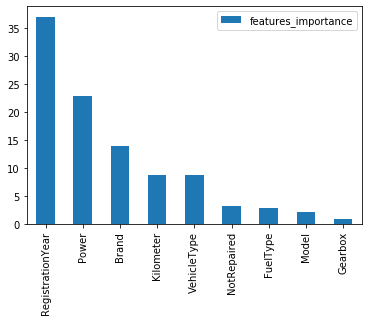

In [75]:
imp.plot(kind='bar')

Год регистрации на первом месте с большим отрывом, так же важными признаками являются Мощность и Фирма (суммарно эти три признака имеют общий вес 70%), дальше примерно с одинаковыми показателями следуют Километраж и Тип кузова. Остальные признаки имеют намного меньшую важность (особенно тип коробки передач - меньше 1%).